In [529]:
import pandas as pd
from datetime import datetime
import numpy as np
import json
import glob
from sklearn.metrics import confusion_matrix
import keras
from datetime import timedelta
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Flatten
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import json
import seaborn as sns
%matplotlib inline

# Feature engineering, modeling, and visualizations

## This notebok contains:

### Feature engineering
- Zillow datasets and features
- Business information joined with Zillow
- Natural language processing features sourced from reviews of businesses in the previous data

### Modeling
- Regression models
- Classification models
- Classification models with weights

### Visualizations
- Scatterplots to examine our metrics compared to true growth
- Violinplots to examine true predictions and the distribution of our metric within them
- distribution of the training and test targets

#### Loading in our flies from Zillow

In [530]:
# Creating a list of Zillow fie names for import and ensuring that all files can be read in properly
list_of_file_names = glob.glob("./zip_2/*.csv")

read_data_list_2 = []
fail_list = []
for i, data in enumerate(list_of_file_names):
    try:
        data = pd.read_csv(data)
        read_data_list_2.append(data)
    except UnicodeDecodeError:
        fail_list.append(i)
list_of_file_names_org = list_of_file_names
# Removing files that do not load properly
for x in fail_list:
    del list_of_file_names[x]

In [531]:
# build loop for data we can work with. Only dates and zip
def build_useful_df(data_list):
    useful_df = []
    for dataset in range(len(data_list)):
        data = read_data_list_2[dataset].copy()
        region_name = data['RegionName']
        region_name = region_name.astype(str)
        new_df = data.select_dtypes(include=['float64'])
        new_df.insert(loc=0, column='RegionName', value=region_name) 
        new_df = new_df.sort_values('RegionName',ascending=False)
        new_df = new_df.set_index('RegionName')
        useful_df.append(new_df)
    return useful_df

In [532]:
# Running the above function and making sure that our files contain enough zipcodes to give us sufficient data to merge

useful_df = build_useful_df(read_data_list_2)
sixteen_list = []
good_columns = []
sixteen_good = []
for i, file in enumerate(useful_df):
    if len(file) >= 10000:
        sixteen_list.append(i)
# Making sure that our files contain up to date information
for i, file in enumerate(useful_df):
    columns = file.columns
    if '2017-01' in columns:
        good_columns.append(i)
# Selecting our list of files to use by cross referencing the lists that define files with attributes that we are looking for
for num in sixteen_list:
    if num in good_columns:
        sixteen_good.append(num)

In [533]:
# Selecting our target data (price per square foot)
target_data = useful_df[23]
# Extracting the files themselves from the glob
final_data_list = []
for i, data in enumerate(useful_df):
    if i in sixteen_good:
        final_data_list.append(data)

In [534]:
# Docs that don't need feature engineering. They are already aggregates. These may be used for future feature engineering
pure_features = [0, 71, 75, 77, 79, 81]
#useful_df[0].head(50)

#### Creating a function that builds features for our model

In [535]:
def make_features(df, past_time_string, now_string):
    #df.dropna(inplace=True)
    features = pd.DataFrame()
    #features['RegionName'] = df['RegionName']
    mean = df.loc[:, past_time_string : now_string].mean(axis=1)
    features['mean'] = mean
    std = df.loc[:, past_time_string : now_string].std(axis=1)
    features['std'] = std
    mn = df.loc[:, past_time_string : now_string].min(axis=1)
    features['min'] = mn
    mx = df.loc[:, past_time_string : now_string].max(axis=1)
    features['max'] = mx
    features['swing'] = mx - mn
    change = df[now_string] - df[past_time_string]
    features['change'] = change
    mean_swing = features['swing'].mean()
    features['swing_pos'] = np.where(features['swing']>mean_swing, 1, 0)
    big_swing = features['swing'].std() + mean_swing
    features['swing_big'] = np.where(features['swing']>big_swing, 1, 0)
    features['swing_neg'] = np.where(features['swing']<mean_swing, 1, 0)
    swing_big_loss = mean_swing - features['swing'].std() 
    features['swing_loss_big'] = np.where(features['swing']<swing_big_loss, 1, 0)
    return features
    
# Creating the time frame we want to utilize for our prediction as well as generting the features and checking the data
# to be certain that it fits the timeframe we are looking for
def make_modeling_data(df_list, df_for_target, now_string):
    df_one = pd.DataFrame()
    target = pd.DataFrame()
    now_time = pd.to_datetime(now_string)
    now_value = df_for_target[now_string]
    future_time = now_time + timedelta(days=6*31)
    future_time_string= future_time.strftime("%Y-%m")
    future_value = df_for_target[future_time_string]
    target['target'] = future_value/now_value
    
    
    past_time = now_time - timedelta(days=6*31)
    past_time_string= past_time.strftime("%Y-%m")
    df_to_use_for_features_org= df_list[0].loc[:, :now_string]
    features_org = make_features(df_to_use_for_features_org, past_time_string, now_string)
    df_one = pd.merge(df_one, features_org, left_index=True, right_index=True, how = 'right')
    for i, df in enumerate(df_list[1:]):
        ind = str(i)
        columns = df.columns
        if '2011-01' in columns and '2012-01' in columns and '2013-01' in columns and '2014-01' in columns and '2015-01' in columns and '2016-01' in columns and '2017-01' in columns:
            df_to_use_for_features= df.loc[:, :now_string]
            features = make_features(df_to_use_for_features, past_time_string, now_string)
            df_one = pd.merge(df_one, features, right_index=True, left_index=True, how='inner')
    target = target.loc[df_one.index]    
    

    
    return df_one, target



# Generate the initial modeling data
test_features, test_targets = make_modeling_data(final_data_list, target_data, "2017-06")
train_features, train_targets = make_modeling_data(final_data_list, target_data, "2017-01")
train_features = train_features.append(train_features)
train_targets = train_targets.append(train_targets)






# Specifying different timeframes that we will use to generate data from the past and appending it to our training dataset
date_counter = 0
for year in ["2012", "2013", "2014", "2015", "2016"]:
    for month in ["06","12"]:
            new_time = year+"-"+month
            date_counter += 1
            extra_train_features, extra_train_targets = make_modeling_data(final_data_list, target_data, new_time)
            train_features = train_features.append(extra_train_features)
            train_targets = train_targets.append(extra_train_targets)

#### w2v features

In [536]:
# Importing w2v features
w2v_features = pd.read_csv('real_business_w2v_features_3_6')
# Making sure that the type is compatible with other files
w2v_features['postal_code'] = w2v_features['postal_code'].astype(str)
# Using the zip code as an index
w2v_features.index = w2v_features['postal_code']
# Removing unnecessary columns
w2v_features = w2v_features.iloc[:, 1:]

#### Business features

In [537]:
# Importing business data features
business_features = pd.read_csv('real_business_features_3_4')
# Making sure that the type is compatible with other files
business_features['postal_code'] = business_features['postal_code'].astype(str)
# Using the zip code as an index
business_features = business_features.set_index('postal_code')

#### Adjusting train test sets

In [538]:
# Resetting the index for the Zillow features
train_features = train_features.reset_index()
test_features = test_features.reset_index()
train_targets = train_targets.reset_index()
test_targets = test_targets.reset_index()

In [539]:
# Merging on index for train and test features and targets so it doesn't multiply rows as well as resetting the index to zips
train_merge = pd.merge(train_features, train_targets, right_index=True, left_index=True, how='inner')
test_merge = pd.merge(test_features, test_targets, right_index=True, left_index=True, how='inner')
train_merge = train_merge.set_index('RegionName_x')
test_merge = test_merge.set_index('RegionName_x')

In [540]:
# Merging on index for business train and test features and targets so it doesn't multiply rows
business_train_merge = pd.merge(train_merge, business_features, right_index=True, left_index=True, how='inner')
business_test_merge = pd.merge(test_merge, business_features, right_index=True, left_index=True, how='inner')

In [541]:
# Merging on index for w2v train and test features and targets so it doesn't multiply rows
w2v_train_merge = pd.merge(train_merge, w2v_features, right_index=True, left_index=True, how='inner')
w2v_test_merge = pd.merge(test_merge, w2v_features, right_index=True, left_index=True, how='inner')

In [542]:
# Making sure that all zipcodes are shared in the different feature sets and dropping NA values
new_zillow_test_merge = pd.merge(test_merge, business_features, right_index=True, left_index=True, how='inner')
test_merge = new_zillow_test_merge.iloc[:, :-10]
new_zillow_train_merge = pd.merge(train_merge, business_features, right_index=True, left_index=True, how='inner')
train_merge = new_zillow_train_merge.iloc[:, :-10]
train_merge = train_merge.drop('RegionName_y', 1)
test_merge = test_merge.drop('RegionName_y', 1)
train_merge.dropna(inplace=True)
test_merge.dropna(inplace=True)
business_train_merge.dropna(inplace=True)
business_test_merge.dropna(inplace=True)
w2v_train_merge.dropna(inplace=True)
w2v_test_merge.dropna(inplace=True)
test_merge.to_csv('test_set_final.csv')

#### Creating arrays and train test splits

In [543]:
# Creating Zillow train/test arrays
X_train = train_merge.iloc[:, :-1].values
y_train = train_merge.iloc[:, -1].values
X_test = test_merge.iloc[:, :-1].values
y_test = test_merge.iloc[:, -1].values

# Creating Zillow + business train/test arrays and dropping redundant columns
business_train_merge = business_train_merge.drop('RegionName_y', 1)
business_test_merge = business_test_merge.drop('RegionName_y', 1)
y_train_business = business_train_merge.loc[:, 'target'].values
y_test_business = business_test_merge.loc[:, 'target'].values
business_train = pd.DataFrame()
business_train_features = business_train_merge.drop('target', 1).values
X_train_business = pd.DataFrame()
X_train_business = business_train_features
X_test_business_features = pd.DataFrame()
X_test_business_features = business_test_merge.drop('target', 1).values
X_test_business = pd.DataFrame()
X_test_business = X_test_business_features

# Creating Zillow + business + NLP train/test arrays and dropping redundant columns
w2v_train_merge = w2v_train_merge.drop('RegionName_y', 1)
w2v_test_merge = w2v_test_merge.drop('RegionName_y', 1)
y_train_w2v = w2v_train_merge.loc[:, 'target'].values
y_test_w2v = w2v_test_merge.loc[:, 'target'].values
w2v_train = pd.DataFrame()
w2v_train_features = w2v_train_merge.drop('target', 1).values
X_train_w2v = pd.DataFrame()
X_train_w2v = w2v_train_features
X_test_w2v_features = pd.DataFrame()
X_test_w2v_features = w2v_test_merge.drop('target', 1).values
X_test_w2v = pd.DataFrame()
X_test_w2v = X_test_w2v_features

#### Normalizing the arrays

In [544]:
# Creating a function that normalizes the arrays
def norm_per_column(X):
    new_array = []
    shape = X.shape
    columns = shape[1]
    for num in range(columns):
        mx = X[:, num].max()
        if mx == 0:
            new_array.append(X[:, num])
        else:
            X[:, num] = X[:, num] / mx
            new_array.append(X[:, num])
    new_array = np.array(new_array)
    new_array = np.transpose(new_array)
    return new_array

In [545]:
# Normalizing the arrays
X_train = norm_per_column(X_train)
X_test = norm_per_column(X_test)
X_train_business = norm_per_column(X_train_business)
X_test_business = norm_per_column(X_test_business)
X_train_w2v = norm_per_column(X_train_w2v)
X_test_w2v = norm_per_column(X_test_w2v)

# Checking the variance to see how well the regression model performs
y_test.var()

0.0028560998107322942

In [546]:
# Checking to see if the training set and test set are dramatically different
print('train mean')
print(y_train.mean())
print('train min')
print(y_train.min())
print('train max')
print(y_train.max())
print('test mean')
print(y_test.mean())
print('test min')
print(y_test.min())
print('test max')
print( y_test.max())

train mean
1.03568676443
train min
0.809566962437
train max
1.32300764356
test mean
1.01812630226
test min
0.833675690212
test max
1.18704258259


#### Creating classes for targets

In [547]:
# Defining a function to generate classes for categorical model
def create_y_class_2(y_list):
    y_df = pd.DataFrame()
    y_1 = []
    y_2 = []
    y_3 = []
    y_4 = []
    y_5 = []
    
    for y in y_list:
        if y <= .9:
            y_1.append(1)
        else:
            y_1.append(0)
        if y > .9 and y <= .97:
            y_2.append(1)
        else:
            y_2.append(0)
        if y > .97 and y < 1.03:
            y_3.append(1)
        else:
            y_3.append(0)
        if y >= 1.03 and y < 1.1:
            y_4.append(1)
        else:
            y_4.append(0)
        if y >= 1.1:
            y_5.append(1)
        else:
            y_5.append(0)
    y_df['1'] = y_1
    y_df['2'] = y_2
    y_df['3'] = y_3
    y_df['4'] = y_4
    y_df['5'] = y_5
    return y_df

In [548]:
# Creating classes for categorical model
y_cat_train = create_y_class_2(y_train)
y_cat_test = create_y_class_2(y_test)
y_cat_train_w2v = create_y_class_2(y_train_w2v)
y_cat_test_w2v = create_y_class_2(y_test_w2v)
y_cat_train_business = create_y_class_2(y_train_business)
y_cat_test_business = create_y_class_2(y_test_business)
y_test_business.var()

0.0028560998107322942

#### Regression Models

In [509]:
model = Sequential()
model.add(Dense(300, input_shape=(120,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.005)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [ ]:
model.fit(x=X_train, y=y_train, 
          batch_size=2000, 
          epochs=200, 
          verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=None)

In [740]:
model = Sequential()
model.add(Dense(300, input_shape=(130,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.01)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [ ]:
model.fit(x=X_train_business, y=y_train_business, 
          batch_size=2000, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test_business, y_test_business),
          callbacks=None)

In [745]:
model = Sequential()
model.add(Dense(300, input_shape=(631,), activation='relu'))
model.add(Dropout(.35))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(25, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dropout(.35))
model.add(Dense(1, activation='linear'))
ada = keras.optimizers.Adagrad()
adam = keras.optimizers.Adam(lr=0.001)
rms = keras.optimizers.RMSprop(lr=0.002)
sgd = keras.optimizers.SGD(lr=0.75)
model.compile(optimizer=rms,
              loss='mean_squared_error')

In [ ]:
model.fit(x=X_train_w2v, y=y_train_w2v, 
          batch_size=2000, 
          epochs=500, 
          verbose=1, 
          validation_data=(X_test_w2v, y_test_w2v),
          callbacks=None)

#### Switching to categorical model and generating metrics to analyze performance


In [549]:
# Generating metrics for categorical model
def model_metrics(predictions, y_test, x_train):
    df = pd.DataFrame(predictions) 
    zips = x_train.index
    df['zips'] = zips
    predicted_classes = predictions.argmax(axis=1)
    # predicting a loss 3% or larger by seeing if max loss probability is higher then slight gain
    df['loss'] = np.where(df[0] > df[3], 1, 0)
    # predicting a gain 3% or larger by seeing if max gain probability is higher then slight loss
    df['gain'] = np.where(df[4] > df[1], 1, 0)
    df = pd.merge(df, y_test, left_index=True, right_index=True, how='inner')
    # predicting a loss 3% or larger by seeing if max loss probability is higher then mean probibility 
    df['loss_large'] = np.where(df[0] > df[2], 1, 0)
    # predicting a gain 3% or larger by seeing if max gain probability is higher then mean probibility 
    df['gain_large'] = np.where(df[4] > df[2], 1, 0)
    # Cheching if loss is predicted and a loss of 3% or more occurs
    df['loss_true_true'] = np.where((df['loss'] == 1) & ((df['2'] == 1) | (df['1'] == 1)), 1, 0)
    # Checking if loss is predicted and price stays at the mean
    df['loss_stay'] = np.where((df['loss'] == 1) & (df['3'] == 1), 1, 0)
    # Cheching if large loss is predicted and a loss of 3% or more occurs
    df['loss_large_true'] = np.where((df['loss_large'] == 1) & ((df['2'] == 1) | (df['1'] == 1)), 1, 0)
    # Cheching if large loss is predicted and price stays at the mean
    df['loss_large_stay'] = np.where((df['loss_large'] == 1) & (df['3'] == 1), 1, 0)
    # Cheching if gain is predicted and a loss of 3% or more occurs
    df['gain_true_true'] = np.where((df['gain'] == 1) & ((df['4'] == 1) | (df['5'] == 1)), 1, 0)
    # Checking if gain is predicted and price stays at the mean
    df['gain_stay'] = np.where((df['gain'] == 1) & (df['3'] == 1), 1, 0)
    # Cheching if large gain is predicted and a gain of 3% or more occurs
    df['gain_large_true'] = np.where((df['gain_large'] == 1) & ((df['4'] == 1) | (df['5'] == 1)), 1, 0)
    # Cheching if large gain is predicted and price stays at the mean
    df['gain_large_stay'] = np.where((df['gain_large'] == 1) & (df['3'] == 1), 1, 0)
    #df['gain_large_large'] = np.where((df['gain_large'] == 1) & (df['5'] == 1), 1, 0)
    # Checking if both loss and gain are selected. This appears to mean high volitility
    df['volitile'] = np.where((df['loss'] == 1) & (df['gain'] == 1), 1, 0)
    df['top_vs_mean_low'] = (df[4] + df[3]) - (df[2] + df[1])
    #df['zips'] = df.index
    df = df.sort_values('top_vs_mean_low', ascending=False)
    top_10 = []
    # Here I switched 10% to 15% to generate a better comparison. In production this may revert to 10%
    top = round(len(df) * .15)
    for num in range(top):
        top_10.append(1)
    finish_list = len(df) - len(top_10)
    for num in range(finish_list):
        top_10.append(0)
    df['top_vs_mean_low_select'] = top_10
    df['top_vs_mean_low_select_true'] = np.where((df['top_vs_mean_low_select'] == 1) & ((df['4'] == 1) | (df['5'] == 1)), 1, 0)
    df['top_vs_mean_low_select_large'] = np.where((df['top_vs_mean_low_select'] == 1) & (df['5'] == 1), 1, 0)
    df['gain_large_true_large'] = np.where((df['gain'] == 1) & (df['5'] == 1), 1, 0)
    df['top_vs_mean_low_select_mean'] = np.where((df['top_vs_mean_low_select'] == 1) & (df['3'] == 1), 1, 0)
    df['predicted_classes'] = predicted_classes
    df['predicted_classes_gain'] = np.where((df['predicted_classes'] == 3) | (df['predicted_classes'] == 4) , 1, 0)
    df['predicted_classes_gain_true'] = np.where((df['predicted_classes_gain'] == 1)  & ((df['4'] == 1) | (df['5'] == 1)), 1, 0)
    df['predicted_classes_gain_large_true'] = np.where((df['predicted_classes_gain'] == 1) & (df['5'] == 1), 1, 0)
    df['predicted_classes_gain_mean'] = np.where((df['predicted_classes_gain'] == 1) & (df['3'] == 1), 1, 0)
    df['gain_true'] = np.where((df['4'] == 1) | (df['5'] == 1), 1, 0)
    df = df.set_index('zips')
    
    gain_pred = df['gain'].sum()
    gain_large_pred = df['gain_large'].sum()
    
    gain_stay_true = (df['gain_true_true'].sum() + df['gain_stay'].sum()) / df['gain'].sum()
    
    # Since we are focused on gain at the moment the loss predictions are commited out. This may change in production
    gain_true = df['gain_true_true'].sum() / df['gain'].sum()
    #loss_stay_true = (df['loss_true_true'].sum() + df['loss_stay'].sum()) / df['loss'].sum()
    #loss_stay_true = df['loss_true_true'].sum() / df['loss'].sum()
    gain_stay_large_true = (df['gain_large_true'].sum() + df['gain_large_stay'].sum()) / df['gain_large'].sum()
    gain_large_true = df['gain_large_true'].sum() / df['gain_large'].sum()
    #loss_stay_large_true = (df['loss_large_true'].sum() + df['loss_large_stay']) / df['loss_large'].sum()
    #loss_large_true = df['loss_large_true'].sum() / df['loss_large'].sum()
    volitile = df['volitile'].sum()
    four_five_split = df['top_vs_mean_low_select_true'].sum() / df['top_vs_mean_low_select'].sum()
    four_five_split_large = df['top_vs_mean_low_select_large'].sum() / df['top_vs_mean_low_select'].sum()
    four_five_split_mean = (df['top_vs_mean_low_select_true'].sum() + df['top_vs_mean_low_select_mean'].sum()) / df['top_vs_mean_low_select'].sum()
    predicted_classes_gain_true = df['predicted_classes_gain_true'].sum() / df['predicted_classes_gain'].sum()
    predicted_classes_gain_large_true = df['predicted_classes_gain_large_true'].sum() / df['predicted_classes_gain'].sum()
    predicted_classes_gain_mean = (df['predicted_classes_gain_true'].sum() + df['predicted_classes_gain_mean'].sum()) / df['predicted_classes_gain'].sum()
    gain_true_large = df['gain_large_true_large'].sum() / df['gain'].sum()
    return gain_pred, gain_true_large, gain_true, gain_stay_true, four_five_split_large, four_five_split, four_five_split_mean, predicted_classes_gain_true, predicted_classes_gain_large_true, predicted_classes_gain_mean, df 

#### Adding weights to classes

In [550]:
class_weight = {0 : 2,
    1: 1,
    2: .5,
    3: 1,
    4: 2}

#### Zillow models and analysis of different tunings and weights

In [ ]:
df_zillow_analysis = pd.DataFrame()
# regularizer that seems to work the best is commented below. Saving the code to repeat when testing the regularizers
#, kernel_regularizer=regularizers.l1(0.0001))
for num in range(5):
    model = Sequential()
    model.add(Dense(300, input_shape=(120,), activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(25, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(5, activation='softmax'))
    ada = keras.optimizers.Adagrad()
    adam = keras.optimizers.Adam(lr=0.001)
    rms = keras.optimizers.RMSprop(lr=0.001)
    sgd = keras.optimizers.SGD(lr=0.75)
    model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    zillow_model_2 = model.fit(x=X_train, y=y_cat_train, 
          batch_size=2000, 
          epochs=175, 
          verbose=1, 
          validation_data=(X_test, y_cat_test),
          callbacks=None,
          class_weight = class_weight)
    
    predictions = model.predict(X_test)
    loss = zillow_model_2.history['val_loss'][-1]
    acc = zillow_model_2.history['val_acc'][-1]
    gain_pred, gain_true_large, gain_true, gain_stay_true, four_five_split_large, four_five_split, four_five_split_mean, predicted_classes_gain_true, predicted_classes_gain_large_true, predicted_classes_gain_mean, df_metrics_z = model_metrics(predictions, y_cat_test, test_merge)
    df_zillow_analysis.loc[num,'pred_count'] = gain_pred
    df_zillow_analysis.loc[num,'gain_10%'] = gain_true_large
    df_zillow_analysis.loc[num,'gain_3%'] = gain_true
    df_zillow_analysis.loc[num,'gain_mean'] = gain_stay_true
    df_zillow_analysis.loc[num,'top_pred_prob_10%'] = four_five_split_large
    df_zillow_analysis.loc[num,'top_pred_prob_3%'] = four_five_split
    df_zillow_analysis.loc[num,'top_pred_prob_mean'] = four_five_split_mean
    df_zillow_analysis.loc[num,'model_pred_prob_10%'] = predicted_classes_gain_large_true
    df_zillow_analysis.loc[num,'model_pred_prob_3%'] = predicted_classes_gain_true
    df_zillow_analysis.loc[num,'model_pred_prob_mean'] = predicted_classes_gain_mean
    df_zillow_analysis.loc[num,'loss'] = loss
    df_zillow_analysis.loc[num,'acc'] = acc
    print(num)
df_175_w_z = df_zillow_analysis
df_zillow_analysis

In [242]:
df_150_z_r

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,331.0,0.060423,0.392749,0.827795,0.14,0.70,0.96,0.060423,0.392749,0.827795,1.551617,0.332326
1,331.0,0.060423,0.392749,0.827795,0.14,0.64,0.96,0.060423,0.392749,0.827795,1.558010,0.332326
2,331.0,0.060423,0.392749,0.827795,0.14,0.74,0.96,0.060423,0.392749,0.827795,1.554780,0.332326
3,331.0,0.060423,0.392749,0.827795,0.16,0.68,0.98,0.060423,0.392749,0.827795,1.561087,0.332326
4,331.0,0.060423,0.392749,0.827795,0.16,0.66,0.94,0.060423,0.392749,0.827795,1.552505,0.332326


In [251]:
df_175_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,128.0,0.125000,0.687500,0.960938,0.24,0.78,0.92,0.069620,0.487342,0.867089,1.297782,0.453172
1,139.0,0.115108,0.661871,0.942446,0.24,0.84,0.96,0.065868,0.491018,0.844311,1.274894,0.459215
2,121.0,0.132231,0.702479,0.950413,0.22,0.80,0.96,0.092199,0.510638,0.829787,1.159747,0.537764
3,119.0,0.134454,0.714286,0.941176,0.22,0.82,0.96,0.084967,0.483660,0.849673,1.210072,0.510574
4,98.0,0.163265,0.785714,0.959184,0.24,0.82,0.96,0.090909,0.530303,0.833333,1.197652,0.498489


In [553]:
df_175_w_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,122.0,0.131148,0.704918,0.967213,0.20,0.80,0.94,0.063830,0.475177,0.865248,1.314027,0.534743
1,99.0,0.161616,0.787879,0.959596,0.22,0.82,0.96,0.109244,0.512605,0.873950,1.256399,0.574018
2,117.0,0.136752,0.709402,0.948718,0.24,0.76,0.92,0.112583,0.483444,0.867550,1.407440,0.459215
3,189.0,0.089947,0.587302,0.920635,0.26,0.80,0.94,0.071749,0.448430,0.856502,1.498032,0.438066
4,107.0,0.149533,0.757009,0.962617,0.22,0.80,0.94,0.078014,0.539007,0.907801,1.307601,0.516616


In [ ]:
df_400_z

In [1176]:
df_300_w_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,116.0,0.094972,0.724138,0.965517,0.272727,0.757576,0.909091,0.055556,0.472222,0.861111,1.484431,0.459215
1,72.0,0.094972,0.791667,0.958333,0.242424,0.757576,0.939394,0.120000,0.540000,0.910000,1.330855,0.534743
2,160.0,0.094972,0.631250,0.937500,0.303030,0.818182,0.939394,0.076142,0.482234,0.878173,1.462107,0.480363
3,109.0,0.094972,0.752294,0.963303,0.242424,0.757576,0.878788,0.070922,0.468085,0.872340,1.376176,0.531722
4,94.0,0.094972,0.755319,0.957447,0.242424,0.757576,0.939394,0.092199,0.475177,0.865248,1.363008,0.519637


In [1182]:
df_300_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,123.0,0.094972,0.707317,0.951220,0.272727,0.757576,0.878788,0.064935,0.461039,0.844156,1.434881,0.507553
1,97.0,0.094972,0.731959,0.969072,0.242424,0.787879,0.939394,0.090909,0.518182,0.909091,1.450340,0.459215
2,95.0,0.094972,0.789474,0.957895,0.242424,0.787879,0.939394,0.077778,0.488889,0.888889,1.533402,0.471299
3,89.0,0.094972,0.741573,0.943820,0.272727,0.787879,0.909091,0.083969,0.488550,0.870229,1.348234,0.513595
4,110.0,0.094972,0.709091,0.936364,0.242424,0.727273,0.909091,0.089655,0.496552,0.868966,1.400084,0.486405


In [1170]:
df_250_w_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,137.0,0.094972,0.671533,0.948905,0.272727,0.787879,0.939394,0.088435,0.537415,0.863946,1.421515,0.510574
1,94.0,0.094972,0.797872,0.957447,0.272727,0.757576,0.909091,0.090090,0.540541,0.846847,1.469787,0.468278
2,157.0,0.094972,0.636943,0.936306,0.303030,0.727273,0.878788,0.075676,0.470270,0.881081,1.468260,0.465257
3,115.0,0.094972,0.739130,0.956522,0.303030,0.757576,0.909091,0.101562,0.500000,0.859375,1.435143,0.480363
4,144.0,0.094972,0.659722,0.951389,0.272727,0.727273,0.909091,0.076471,0.494118,0.876471,1.542414,0.432024


In [1184]:
df_250_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,125.0,0.094972,0.704000,0.968000,0.272727,0.727273,0.909091,0.093960,0.463087,0.852349,1.548896,0.432024
1,88.0,0.094972,0.784091,0.965909,0.272727,0.757576,0.909091,0.115044,0.522124,0.858407,1.321403,0.489426
2,70.0,0.094972,0.757143,0.942857,0.242424,0.787879,0.939394,0.048780,0.495935,0.861789,1.274005,0.546828
3,92.0,0.094972,0.739130,0.934783,0.272727,0.757576,0.939394,0.112903,0.532258,0.830645,1.325635,0.489426
4,98.0,0.094972,0.775510,0.959184,0.242424,0.818182,0.939394,0.094488,0.535433,0.881890,1.214646,0.540785


In [1172]:
df_200_w_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,163.0,0.094972,0.625767,0.938650,0.303030,0.757576,0.909091,0.083770,0.465969,0.879581,1.407345,0.474320
1,144.0,0.094972,0.659722,0.951389,0.303030,0.787879,0.909091,0.092025,0.496933,0.883436,1.437591,0.483384
2,136.0,0.094972,0.669118,0.955882,0.303030,0.787879,0.969697,0.096970,0.515152,0.878788,1.464218,0.465257
3,133.0,0.094972,0.676692,0.954887,0.272727,0.787879,0.909091,0.095890,0.472603,0.842466,1.397490,0.480363
4,110.0,0.094972,0.754545,0.963636,0.272727,0.787879,0.939394,0.097561,0.495935,0.886179,1.270403,0.543807


In [1186]:
df_200_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,93.0,0.094972,0.795699,0.956989,0.272727,0.848485,0.969697,0.094828,0.439655,0.818966,1.196810,0.546828
1,103.0,0.094972,0.718447,0.932039,0.242424,0.757576,0.939394,0.097561,0.430894,0.829268,1.307886,0.483384
2,88.0,0.094972,0.784091,0.954545,0.242424,0.787879,0.939394,0.082569,0.495413,0.871560,1.204385,0.525680
3,82.0,0.094972,0.804878,0.951220,0.242424,0.787879,0.969697,0.078431,0.500000,0.803922,1.294213,0.492447
4,95.0,0.094972,0.768421,0.957895,0.242424,0.787879,0.939394,0.093525,0.525180,0.856115,1.235405,0.489426


In [1174]:
df_150_w_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,76.0,0.094972,0.815789,0.960526,0.212121,0.787879,0.969697,0.107438,0.545455,0.884298,1.245467,0.580060
1,148.0,0.094972,0.668919,0.952703,0.272727,0.818182,0.939394,0.077778,0.461111,0.827778,1.352093,0.513595
2,180.0,0.094972,0.611111,0.916667,0.303030,0.727273,0.909091,0.070796,0.469027,0.858407,1.461635,0.407855
3,169.0,0.094972,0.633136,0.934911,0.272727,0.757576,0.909091,0.071429,0.464286,0.862245,1.357489,0.483384
4,170.0,0.094972,0.623529,0.947059,0.303030,0.787879,0.939394,0.096257,0.524064,0.887701,1.349806,0.474320


In [1188]:
df_150_z

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,106.0,0.094972,0.754717,0.952830,0.272727,0.787879,0.939394,0.081481,0.525926,0.851852,1.184601,0.483384
1,114.0,0.094972,0.745614,0.956140,0.303030,0.757576,0.878788,0.070312,0.507812,0.843750,1.175836,0.480363
2,152.0,0.094972,0.651316,0.953947,0.303030,0.757576,0.909091,0.084746,0.525424,0.847458,1.226775,0.474320
3,142.0,0.094972,0.676056,0.950704,0.333333,0.818182,0.939394,0.093750,0.506250,0.862500,1.246916,0.459215
4,113.0,0.094972,0.734513,0.938053,0.242424,0.787879,0.939394,0.110345,0.475862,0.882759,1.179244,0.513595


#### Zillow plus business models and analysis of different tunings and weights

In [ ]:
df_business_analysis = pd.DataFrame()
# regularizer that seems to work the best is commented below. Saving the code to repeat when testing the regularizers
#, kernel_regularizer=regularizers.l1(0.0001)
for num in range(5):
    model = Sequential()
    model.add(Dense(300, input_shape=(130,), activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(25, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(5, activation='softmax'))
    ada = keras.optimizers.Adagrad()
    adam = keras.optimizers.Adam(lr=0.001)
    rms = keras.optimizers.RMSprop(lr=0.001)
    sgd = keras.optimizers.SGD(lr=0.75)
    model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    business_model_2 = model.fit(x=X_train_business, y=y_cat_train_business, 
          batch_size=2000, 
          epochs=175, 
          verbose=1, 
          validation_data=(X_test_business, y_cat_test_business),
          callbacks=None,
          class_weight = class_weight)
    
    predictions = model.predict(X_test_business)
    loss = business_model_2.history['val_loss'][-1]
    acc = business_model_2.history['val_acc'][-1]
    gain_pred, gain_true_large, gain_true, gain_stay_true, four_five_split_large, four_five_split, four_five_split_mean, predicted_classes_gain_true, predicted_classes_gain_large_true, predicted_classes_gain_mean, df_metrics_b = model_metrics(predictions, y_cat_test_business, business_test_merge)
    df_business_analysis.loc[num,'pred_count'] = gain_pred
    df_business_analysis.loc[num,'gain_10%'] = gain_true_large
    df_business_analysis.loc[num,'gain_3%'] = gain_true
    df_business_analysis.loc[num,'gain_mean'] = gain_stay_true
    df_business_analysis.loc[num,'top_pred_prob_10%'] = four_five_split_large
    df_business_analysis.loc[num,'top_pred_prob_3%'] = four_five_split
    df_business_analysis.loc[num,'top_pred_prob_mean'] = four_five_split_mean
    df_business_analysis.loc[num,'model_pred_prob_10%'] = predicted_classes_gain_large_true
    df_business_analysis.loc[num,'model_pred_prob_3%'] = predicted_classes_gain_true
    df_business_analysis.loc[num,'model_pred_prob_mean'] = predicted_classes_gain_mean
    df_business_analysis.loc[num,'loss'] = loss
    df_business_analysis.loc[num,'acc'] = acc
    print(num)
df_175_w_b = df_business_analysis
df_business_analysis

In [ ]:
df_metrics_b

In [ ]:
df_400_w_b

In [1151]:
df_400_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,79.0,0.094972,0.810127,0.987342,0.272727,0.787879,0.969697,0.117117,0.549550,0.864865,1.373044,0.543807
1,53.0,0.094972,0.830189,0.981132,0.303030,0.848485,1.000000,0.098765,0.604938,0.888889,1.604796,0.477341
2,79.0,0.094972,0.848101,0.987342,0.212121,0.818182,1.000000,0.099099,0.558559,0.882883,1.497453,0.486405
3,108.0,0.094972,0.731481,0.953704,0.272727,0.848485,0.969697,0.100775,0.503876,0.883721,1.519598,0.441088
4,102.0,0.094972,0.754902,0.950980,0.303030,0.757576,0.939394,0.062500,0.506944,0.847222,1.441763,0.510574


In [1141]:
df_300_w_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,76.0,0.094972,0.789474,0.973684,0.242424,0.848485,0.969697,0.142857,0.604396,0.879121,1.312308,0.486405
1,120.0,0.094972,0.700000,0.950000,0.272727,0.818182,0.939394,0.105960,0.543046,0.913907,1.336576,0.483384
2,88.0,0.094972,0.795455,0.977273,0.242424,0.848485,0.969697,0.094340,0.575472,0.924528,1.291740,0.498489
3,113.0,0.094972,0.707965,0.946903,0.242424,0.848485,0.969697,0.090226,0.541353,0.879699,1.287987,0.486405
4,100.0,0.094972,0.750000,0.960000,0.242424,0.848485,0.969697,0.100000,0.558333,0.916667,1.278520,0.507553


In [1153]:
df_300_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,113.0,0.094972,0.699115,0.955752,0.242424,0.878788,0.969697,0.099291,0.560284,0.886525,1.383570,0.429003
1,70.0,0.094972,0.800000,0.971429,0.303030,0.878788,1.000000,0.101124,0.573034,0.898876,1.445286,0.477341
2,47.0,0.094972,0.851064,0.978723,0.242424,0.878788,1.000000,0.077922,0.571429,0.857143,1.424749,0.480363
3,54.0,0.094972,0.851852,0.981481,0.242424,0.878788,0.969697,0.123077,0.553846,0.907692,1.346164,0.429003
4,120.0,0.094972,0.700000,0.950000,0.333333,0.878788,0.969697,0.096774,0.522581,0.851613,1.408535,0.444109


In [1165]:
df_250_w_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,94.0,0.094972,0.744681,0.957447,0.212121,0.818182,0.939394,0.089109,0.584158,0.900990,1.359825,0.435045
1,149.0,0.094972,0.644295,0.939597,0.272727,0.878788,0.969697,0.080000,0.520000,0.891429,1.311240,0.459215
2,79.0,0.094972,0.797468,0.974684,0.212121,0.878788,0.969697,0.111111,0.604938,0.950617,1.358138,0.447130
3,122.0,0.094972,0.704918,0.959016,0.242424,0.787879,0.939394,0.106667,0.533333,0.886667,1.275713,0.516616
4,87.0,0.094972,0.793103,0.965517,0.242424,0.818182,0.939394,0.092437,0.554622,0.890756,1.231637,0.522659


In [1163]:
df_250_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,100.0,0.094972,0.740000,0.970000,0.242424,0.878788,0.969697,0.094017,0.564103,0.880342,1.310063,0.462236
1,82.0,0.094972,0.768293,0.975610,0.242424,0.818182,0.939394,0.097087,0.572816,0.902913,1.340102,0.465257
2,90.0,0.094972,0.800000,0.966667,0.272727,0.848485,0.939394,0.134615,0.605769,0.903846,1.218421,0.495468
3,59.0,0.094972,0.813559,0.966102,0.272727,0.848485,0.969697,0.074468,0.521277,0.851064,1.308485,0.495468
4,60.0,0.094972,0.833333,0.966667,0.242424,0.878788,0.969697,0.072289,0.530120,0.903614,1.210499,0.504532


In [1143]:
df_200_w_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,113.0,0.094972,0.716814,0.955752,0.272727,0.818182,0.939394,0.094488,0.527559,0.897638,1.344561,0.416918
1,109.0,0.094972,0.733945,0.972477,0.212121,0.848485,0.969697,0.108333,0.575000,0.900000,1.296870,0.486405
2,129.0,0.094972,0.697674,0.953488,0.272727,0.878788,0.969697,0.089655,0.551724,0.882759,1.373079,0.422961
3,129.0,0.094972,0.666667,0.945736,0.272727,0.848485,0.969697,0.077844,0.508982,0.862275,1.287742,0.474320
4,134.0,0.094972,0.649254,0.932836,0.242424,0.878788,0.969697,0.085366,0.536585,0.926829,1.338315,0.453172


In [1155]:
df_200_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,94.0,0.094972,0.776596,0.957447,0.303030,0.878788,0.969697,0.114583,0.552083,0.854167,1.344601,0.416918
1,116.0,0.094972,0.715517,0.956897,0.333333,0.818182,0.939394,0.102362,0.566929,0.897638,1.417642,0.365559
2,95.0,0.094972,0.757895,0.968421,0.333333,0.848485,0.969697,0.097087,0.563107,0.893204,1.303192,0.444109
3,73.0,0.094972,0.808219,0.972603,0.242424,0.848485,0.939394,0.101124,0.629213,0.898876,1.126423,0.534743
4,75.0,0.094972,0.813333,0.973333,0.272727,0.848485,0.939394,0.125000,0.650000,0.950000,1.243225,0.462236


In [253]:
df_175_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,135.0,0.103704,0.681481,0.955556,0.28,0.86,0.96,0.098160,0.539877,0.865031,1.162874,0.501511
1,75.0,0.173333,0.826667,0.973333,0.20,0.86,0.96,0.112245,0.561224,0.867347,1.105068,0.525680
2,87.0,0.126437,0.781609,0.977011,0.16,0.82,0.96,0.094737,0.578947,0.905263,1.147732,0.480363
3,127.0,0.110236,0.700787,0.952756,0.20,0.82,0.96,0.103226,0.567742,0.935484,1.108600,0.525680
4,107.0,0.130841,0.738318,0.953271,0.24,0.84,0.94,0.114035,0.614035,0.885965,1.234723,0.435045


In [429]:
df_175_w_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,111.0,0.126126,0.720721,0.963964,0.20,0.86,0.96,0.063492,0.539683,0.873016,1.239896,0.489426
1,145.0,0.103448,0.655172,0.944828,0.22,0.84,0.96,0.083799,0.541899,0.877095,1.240350,0.477341
2,112.0,0.133929,0.732143,0.973214,0.24,0.88,0.96,0.095238,0.603175,0.880952,1.227754,0.549849
3,104.0,0.134615,0.721154,0.971154,0.20,0.86,0.96,0.108108,0.576577,0.864865,1.230924,0.501511
4,108.0,0.138889,0.740741,0.962963,0.22,0.86,0.96,0.090164,0.508197,0.909836,1.199325,0.510574


In [1157]:
df_175_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,88.0,0.094972,0.750000,0.977273,0.212121,0.909091,0.969697,0.085470,0.547009,0.880342,1.122820,0.510574
1,84.0,0.094972,0.797619,0.976190,0.303030,0.878788,0.969697,0.091743,0.596330,0.889908,1.209980,0.465257
2,83.0,0.094972,0.795181,0.975904,0.242424,0.878788,0.969697,0.102804,0.672897,0.925234,1.187737,0.495468
3,118.0,0.094972,0.703390,0.949153,0.272727,0.909091,0.969697,0.091603,0.595420,0.870229,1.238466,0.425982
4,86.0,0.094972,0.790698,0.976744,0.272727,0.878788,0.969697,0.086022,0.602151,0.924731,1.262683,0.432024


In [1145]:
df_150_w_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,100.0,0.094972,0.770000,0.960000,0.272727,0.878788,0.969697,0.095652,0.565217,0.895652,1.287202,0.480363
1,121.0,0.094972,0.694215,0.958678,0.242424,0.909091,0.969697,0.086667,0.500000,0.873333,1.296553,0.486405
2,78.0,0.094972,0.769231,0.961538,0.242424,0.878788,0.969697,0.097087,0.582524,0.912621,1.235172,0.477341
3,167.0,0.094972,0.628743,0.940120,0.242424,0.878788,0.969697,0.061856,0.469072,0.855670,1.307907,0.468278
4,144.0,0.094972,0.673611,0.958333,0.272727,0.878788,0.969697,0.095808,0.550898,0.880240,1.262887,0.492447


In [1159]:
df_150_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,101.0,0.094972,0.762376,0.960396,0.272727,0.848485,0.939394,0.097345,0.566372,0.911504,1.193644,0.462236
1,95.0,0.094972,0.768421,0.978947,0.272727,0.909091,0.969697,0.102804,0.514019,0.850467,1.160346,0.471299
2,97.0,0.094972,0.731959,0.969072,0.242424,0.878788,0.969697,0.099099,0.567568,0.891892,1.125869,0.507553
3,99.0,0.094972,0.787879,0.969697,0.242424,0.848485,0.969697,0.091743,0.568807,0.871560,1.230654,0.459215
4,99.0,0.094972,0.767677,0.959596,0.272727,0.818182,0.939394,0.121495,0.598131,0.887850,1.229660,0.422961


In [1149]:
df_125_w_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,109.0,0.094972,0.715596,0.963303,0.272727,0.878788,0.969697,0.088608,0.512658,0.879747,1.287235,0.495468
1,175.0,0.094972,0.594286,0.942857,0.242424,0.848485,0.969697,0.069519,0.497326,0.877005,1.263305,0.501511
2,200.0,0.094972,0.570000,0.910000,0.272727,0.848485,0.969697,0.074890,0.462555,0.859031,1.357800,0.404834
3,155.0,0.094972,0.651613,0.941935,0.242424,0.878788,0.969697,0.091954,0.500000,0.862069,1.321788,0.477341
4,130.0,0.094972,0.676923,0.953846,0.272727,0.909091,0.969697,0.071429,0.494505,0.895604,1.252489,0.507553


In [1161]:
df_125_b

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,161.0,0.094972,0.621118,0.925466,0.242424,0.848485,0.969697,0.074074,0.486772,0.878307,1.159453,0.480363
1,101.0,0.094972,0.762376,0.980198,0.272727,0.878788,0.969697,0.093023,0.558140,0.906977,1.137560,0.492447
2,95.0,0.094972,0.789474,0.978947,0.272727,0.878788,0.969697,0.117647,0.588235,0.882353,1.065054,0.549849
3,186.0,0.094972,0.591398,0.919355,0.303030,0.848485,0.969697,0.080000,0.485000,0.870000,1.223903,0.447130
4,101.0,0.094972,0.722772,0.960396,0.242424,0.818182,0.969697,0.106195,0.592920,0.911504,1.195224,0.465257


#### Zillow plus business and w2v models and analysis of different tunings and weights

In [ ]:
w2v_cluster_models = []
df_w2v_analysis = pd.DataFrame()
#, kernel_regularizer=regularizers.l1(0.0001)
for num in range(5):
    model = Sequential()
    model.add(Dense(300, input_shape=(631,), activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(25, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
    model.add(Dropout(.35))
    model.add(Dense(5, activation='softmax'))
    ada = keras.optimizers.Adagrad()
    adam = keras.optimizers.Adam(lr=0.001)
    rms = keras.optimizers.RMSprop(lr=0.001)
    sgd = keras.optimizers.SGD(lr=0.75)
    model.compile(optimizer=rms,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    w2v_model_2 = model.fit(x=X_train_w2v, y=y_cat_train_w2v, 
          batch_size=2000, 
          epochs=300, 
          verbose=1, 
          validation_data=(X_test_w2v, y_cat_test_w2v),
          callbacks=None,
          class_weight = class_weight)
    
    predictions = model.predict(X_test_w2v)
    loss = w2v_model_2.history['val_loss'][-1]
    acc = w2v_model_2.history['val_acc'][-1]
    gain_pred, gain_true_large, gain_true, gain_stay_true, four_five_split_large, four_five_split, four_five_split_mean, predicted_classes_gain_true, predicted_classes_gain_large_true, predicted_classes_gain_mean, df_metrics_w2v = model_metrics(predictions, y_cat_test_w2v, w2v_test_merge)
    df_w2v_analysis.loc[num,'pred_count'] = gain_pred
    df_w2v_analysis.loc[num,'gain_10%'] = gain_true_large
    df_w2v_analysis.loc[num,'gain_3%'] = gain_true
    df_w2v_analysis.loc[num,'gain_mean'] = gain_stay_true
    df_w2v_analysis.loc[num,'top_pred_prob_10%'] = four_five_split_large
    df_w2v_analysis.loc[num,'top_pred_prob_3%'] = four_five_split
    df_w2v_analysis.loc[num,'top_pred_prob_mean'] = four_five_split_mean
    df_w2v_analysis.loc[num,'model_pred_prob_10%'] = predicted_classes_gain_large_true
    df_w2v_analysis.loc[num,'model_pred_prob_3%'] = predicted_classes_gain_true
    df_w2v_analysis.loc[num,'model_pred_prob_mean'] = predicted_classes_gain_mean
    df_w2v_analysis.loc[num,'loss'] = loss
    df_w2v_analysis.loc[num,'acc'] = acc
    print(num)
df_300_w = df_w2v_analysis
df_w2v_analysis

In [156]:
df_500_w

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,40.0,0.200000,0.825000,0.950000,0.18,0.84,0.96,0.076087,0.510870,0.902174,1.485391,0.451515
1,73.0,0.178082,0.753425,0.958904,0.22,0.84,0.96,0.099174,0.504132,0.859504,1.418552,0.451515
2,104.0,0.134615,0.711538,0.932692,0.22,0.84,0.96,0.075472,0.509434,0.830189,1.582820,0.381818
3,83.0,0.156627,0.722892,0.963855,0.24,0.80,0.96,0.089041,0.445205,0.883562,1.391745,0.484848
4,99.0,0.131313,0.707071,0.959596,0.20,0.80,0.96,0.086614,0.496063,0.874016,1.708369,0.381818


In [162]:
df_450_w

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,80.0,0.175000,0.762500,0.962500,0.22,0.80,0.96,0.091743,0.550459,0.834862,1.521373,0.424242
1,49.0,0.204082,0.816327,0.959184,0.22,0.84,0.96,0.093023,0.593023,0.906977,1.509003,0.451515
2,109.0,0.137615,0.715596,0.963303,0.22,0.80,0.96,0.088608,0.443038,0.879747,1.464449,0.451515
3,41.0,0.219512,0.804878,0.951220,0.22,0.84,0.96,0.112500,0.625000,0.925000,1.489063,0.451515
4,86.0,0.162791,0.709302,0.953488,0.24,0.82,0.96,0.103175,0.539683,0.928571,1.368972,0.515152


In [1121]:
df_400_w

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,87.0,0.094972,0.758621,0.977011,0.303030,0.848485,0.939394,0.087302,0.539683,0.904762,1.414496,0.432024
1,137.0,0.094972,0.671533,0.948905,0.303030,0.848485,0.939394,0.069519,0.491979,0.866310,1.475380,0.416918
2,54.0,0.094972,0.777778,0.962963,0.242424,0.818182,0.939394,0.069565,0.539130,0.886957,1.399635,0.459215
3,100.0,0.094972,0.720000,0.960000,0.272727,0.787879,0.939394,0.086331,0.496403,0.848921,1.491990,0.438066
4,111.0,0.094972,0.684685,0.945946,0.303030,0.787879,0.939394,0.072993,0.481752,0.854015,1.385046,0.471299


In [1119]:
# Without weights, 400 epochs
df_400

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,52.0,0.094972,0.788462,0.961538,0.272727,0.848485,0.969697,0.090164,0.557377,0.877049,1.543366,0.450151
1,45.0,0.094972,0.755556,0.955556,0.272727,0.787879,0.939394,0.095652,0.486957,0.878261,1.527017,0.456193
2,44.0,0.094972,0.772727,0.954545,0.272727,0.757576,0.939394,0.105263,0.526316,0.921053,1.605956,0.456193
3,47.0,0.094972,0.872340,0.978723,0.242424,0.787879,0.969697,0.064103,0.615385,0.923077,1.634043,0.444109
4,70.0,0.094972,0.771429,0.971429,0.212121,0.787879,0.969697,0.085714,0.528571,0.878571,1.477137,0.471299


In [557]:
# Best
df_300_w

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,89.0,0.146067,0.741573,0.966292,0.22,0.78,0.96,0.095652,0.521739,0.843478,1.408911,0.451515
1,120.0,0.116667,0.658333,0.925000,0.22,0.80,0.96,0.076433,0.452229,0.866242,1.348672,0.460606
2,83.0,0.168675,0.710843,0.939759,0.22,0.76,0.96,0.080357,0.508929,0.848214,1.534324,0.412121
3,122.0,0.122951,0.672131,0.934426,0.24,0.84,0.96,0.092715,0.490066,0.887417,1.583446,0.378788
4,81.0,0.160494,0.728395,0.962963,0.26,0.84,0.96,0.082090,0.514925,0.895522,1.463503,0.427273


In [255]:
df_300

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,62.0,0.193548,0.790323,0.951613,0.20,0.76,0.98,0.087591,0.459854,0.868613,1.530630,0.500000
1,99.0,0.141414,0.717172,0.949495,0.20,0.86,1.00,0.069149,0.468085,0.851064,1.518007,0.418182
2,89.0,0.146067,0.741573,0.943820,0.22,0.78,0.96,0.118182,0.490909,0.845455,1.780207,0.430303
3,44.0,0.181818,0.818182,0.954545,0.18,0.82,0.96,0.074627,0.552239,0.880597,1.715226,0.400000
4,77.0,0.168831,0.779221,0.961039,0.24,0.84,0.96,0.105691,0.528455,0.878049,1.582686,0.463636


In [1131]:
# Without weights, 225 epochs
df_225

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,85.0,0.094972,0.705882,0.941176,0.242424,0.757576,0.939394,0.081522,0.434783,0.847826,1.230999,0.447130
1,123.0,0.094972,0.674797,0.934959,0.272727,0.727273,0.939394,0.086294,0.477157,0.832487,1.229504,0.447130
2,112.0,0.094972,0.678571,0.928571,0.272727,0.848485,0.969697,0.064220,0.440367,0.857798,1.281605,0.398792
3,61.0,0.094972,0.819672,0.967213,0.242424,0.787879,0.939394,0.092308,0.507692,0.846154,1.268600,0.416918
4,60.0,0.094972,0.783333,0.966667,0.272727,0.757576,0.939394,0.090909,0.484848,0.863636,1.282214,0.456193


In [1123]:
# Weights, 225 epochs
df_225_w

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,191.0,0.094972,0.570681,0.926702,0.272727,0.757576,0.909091,0.088372,0.488372,0.879070,1.429407,0.410876
1,71.0,0.094972,0.732394,0.957746,0.303030,0.818182,0.939394,0.071429,0.428571,0.842857,1.344073,0.471299
2,59.0,0.094972,0.796610,0.966102,0.303030,0.818182,0.939394,0.125000,0.556818,0.840909,1.387137,0.429003
3,119.0,0.094972,0.663866,0.941176,0.303030,0.818182,0.969697,0.083916,0.496503,0.860140,1.544066,0.380665
4,142.0,0.094972,0.640845,0.929577,0.272727,0.787879,0.969697,0.078125,0.447917,0.843750,1.357028,0.465257


In [1127]:
df_175

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,128.0,0.094972,0.664062,0.937500,0.242424,0.757576,0.939394,0.061404,0.421053,0.850877,1.198510,0.407855
1,154.0,0.094972,0.597403,0.909091,0.272727,0.727273,0.939394,0.068293,0.448780,0.863415,1.237291,0.429003
2,249.0,0.094972,0.469880,0.867470,0.303030,0.787879,0.969697,0.066176,0.408088,0.845588,1.319757,0.386707
3,183.0,0.094972,0.584699,0.923497,0.242424,0.818182,0.969697,0.073733,0.433180,0.843318,1.329758,0.371601
4,208.0,0.094972,0.524038,0.913462,0.272727,0.757576,0.909091,0.065041,0.439024,0.833333,1.331992,0.419940


In [1125]:
df_175_w

,pred_count,gain_10%,gain_3%,gain_mean,top_pred_prob_10%,top_pred_prob_3%,top_pred_prob_mean,model_pred_prob_10%,model_pred_prob_3%,model_pred_prob_mean,loss,acc
0,62.0,0.094972,0.741935,0.951613,0.272727,0.848485,0.969697,0.059113,0.394089,0.832512,1.342970,0.456193
1,179.0,0.094972,0.569832,0.927374,0.272727,0.727273,0.939394,0.063348,0.434389,0.837104,1.422866,0.432024
2,186.0,0.094972,0.575269,0.930108,0.272727,0.727273,0.878788,0.073913,0.426087,0.843478,1.432149,0.404834
3,271.0,0.094972,0.435424,0.837638,0.272727,0.818182,0.969697,0.060403,0.402685,0.828859,1.555367,0.344411
4,211.0,0.094972,0.530806,0.914692,0.272727,0.818182,0.969697,0.082251,0.471861,0.852814,1.608255,0.350453


#### Mean metrics and visualizations

In [590]:
# Taking the mean of the metrics from the best performing model
w_ = df_300_w.mean()

In [592]:
# Creating a DataFrame to merge with the other models to act as a visualization in the presentation
w_ = pd.DataFrame(w_)

In [593]:
w_.columns=['w2v']

In [504]:
df_metrics_tvm = df_metrics_w2v

In [505]:
df_metrics_tvm.to_csv('tvm_metric.csv')

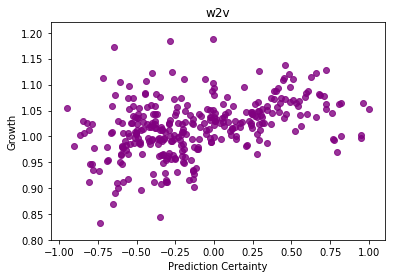

In [559]:
# Generating w2v scatterplot
df_metrics_w2v['y_true'] = y_test_w2v
data_for_model = df_metrics_w2v[['top_vs_mean_low', 'y_true']]
ax_sca_w2v = sns.regplot(data_for_model['top_vs_mean_low'], data_for_model['y_true'], fit_reg=False, color='purple')
ax_sca_w2v.set_title('w2v') 
ax_sca_w2v.set(xlabel='Prediction Certainty', ylabel='Growth')
ax_sca_w2v

[<matplotlib.text.Text at 0x1d51fc748>, <matplotlib.text.Text at 0x1d51f22b0>]

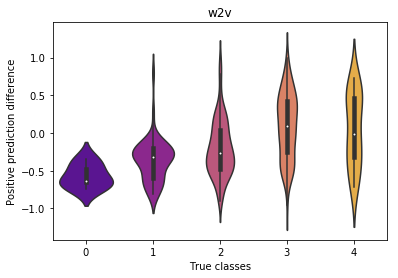

In [573]:
# Generating w2v violinplot
true_classes = y_cat_test_w2v.values.argmax(axis=1)
ax_w2v = sns.violinplot(x=true_classes, y=df_metrics_w2v['top_vs_mean_low'], palette="plasma") 
ax_w2v.set_title('w2v') 
ax_w2v.set(xlabel='True classes', ylabel='Positive prediction difference')

In [574]:
# Buisness model replication of w2v visualizations
w_b = df_175_w_b.mean()

In [599]:
w_b = pd.DataFrame(w_b)

In [600]:
w_b.columns=['business']

In [601]:
w_b

,business
pred_count,124.400000
gain_10%,0.118432
gain_3%,0.694502
gain_mean,0.946651
top_pred_prob_10%,0.228000
top_pred_prob_3%,0.876000
top_pred_prob_mean,0.972000
model_pred_prob_10%,0.091802
model_pred_prob_3%,0.536223
model_pred_prob_mean,0.900136


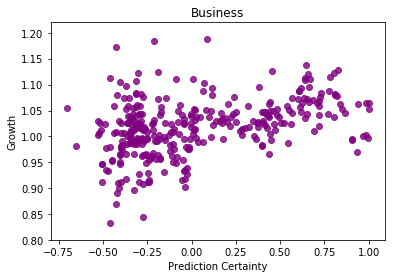

In [563]:
df_metrics_b['y_true'] = y_test_business
data_for_model = df_metrics_b[['top_vs_mean_low', 'y_true']]
ax_sca_b = sns.regplot(data_for_model['top_vs_mean_low'], data_for_model['y_true'], fit_reg=False, color='purple')
ax_sca_b.set_title('Business') 
ax_sca_b.set(xlabel='Prediction Certainty', ylabel='Growth')
ax_sca_b

[<matplotlib.text.Text at 0x1d465d748>, <matplotlib.text.Text at 0x1d4669898>]

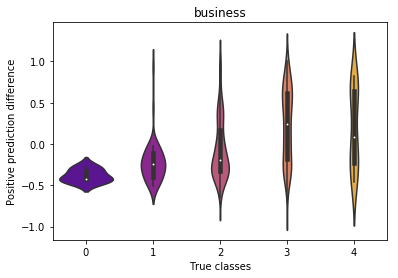

In [570]:
true_classes = y_cat_test.values.argmax(axis=1)
ax_business = sns.violinplot(x=true_classes, y=df_metrics_b['top_vs_mean_low'], palette="plasma")
ax_business.set_title('business')
ax_business.set(xlabel='True classes', ylabel='Positive prediction difference')

In [602]:
# Zillow model replication of w2v visualizations
w_z = df_175_w_z.mean()
w_z = pd.DataFrame(w_z)
w_z.columns=['Zillow']
w_z

,Zillow
pred_count,126.800000
gain_10%,0.133799
gain_3%,0.709302
gain_mean,0.951756
top_pred_prob_10%,0.228000
top_pred_prob_3%,0.796000
top_pred_prob_mean,0.940000
model_pred_prob_10%,0.087084
model_pred_prob_3%,0.491733
model_pred_prob_mean,0.874210


In [603]:
# Merging the metric DataFrames to use in the presentation
metrics_merge_1 = pd.merge(w_z, w_b, right_index=True, left_index=True, how='inner')

In [604]:
metrics_merge_1

,Zillow,business
pred_count,126.800000,124.400000
gain_10%,0.133799,0.118432
gain_3%,0.709302,0.694502
gain_mean,0.951756,0.946651
top_pred_prob_10%,0.228000,0.228000
top_pred_prob_3%,0.796000,0.876000
top_pred_prob_mean,0.940000,0.972000
model_pred_prob_10%,0.087084,0.091802
model_pred_prob_3%,0.491733,0.536223
model_pred_prob_mean,0.874210,0.900136


In [605]:
metrics_merge_2 = pd.merge(metrics_merge_1, w_, right_index=True, left_index=True, how='inner')

In [606]:
metrics_merge_2

,Zillow,business,w2v
pred_count,126.800000,124.400000,99.000000
gain_10%,0.133799,0.118432,0.142971
gain_3%,0.709302,0.694502,0.702255
gain_mean,0.951756,0.946651,0.945688
top_pred_prob_10%,0.228000,0.228000,0.232000
top_pred_prob_3%,0.796000,0.876000,0.804000
top_pred_prob_mean,0.940000,0.972000,0.960000
model_pred_prob_10%,0.087084,0.091802,0.085449
model_pred_prob_3%,0.491733,0.536223,0.497578
model_pred_prob_mean,0.874210,0.900136,0.868175


In [615]:
metrics_merge_3 = metrics_merge_2.iloc[4:7, :]

In [617]:
metrics_merge_3

,Zillow,business,w2v
top_pred_prob_10%,0.228,0.228,0.232
top_pred_prob_3%,0.796,0.876,0.804
top_pred_prob_mean,0.940,0.972,0.960


In [620]:
metrics_merge_3 = metrics_merge_3.append(metrics_merge_2.iloc[-1, :])

In [621]:
# Final metrics we were looking at
metrics_merge_3

,Zillow,business,w2v
top_pred_prob_10%,0.228000,0.228000,0.232000
top_pred_prob_3%,0.796000,0.876000,0.804000
top_pred_prob_mean,0.940000,0.972000,0.960000
acc,0.504532,0.477946,0.426061


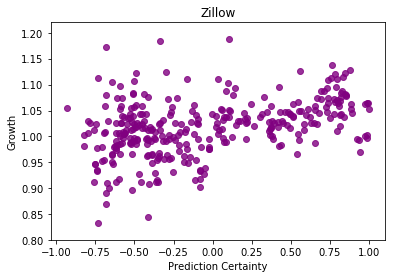

In [567]:
df_metrics_z['y_true'] = y_test
data_for_model = df_metrics_z[['top_vs_mean_low', 'y_true']]
ax_sca_z = sns.regplot(data_for_model['top_vs_mean_low'], data_for_model['y_true'], fit_reg=False, color='purple')
ax_sca_z.set_title('Zillow') 
ax_sca_z.set(xlabel='Prediction Certainty', ylabel='Growth')
ax_sca_z

[<matplotlib.text.Text at 0x1d3601a20>, <matplotlib.text.Text at 0x1d31973c8>]

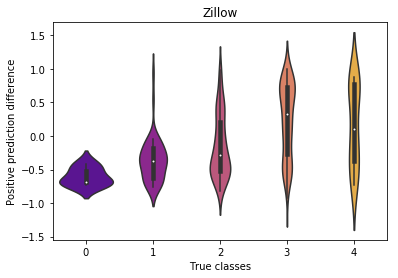

In [568]:
true_classes = y_cat_test.values.argmax(axis=1)
ax_zillow = sns.violinplot(x=true_classes, y=df_metrics_z['top_vs_mean_low'], palette="plasma")
ax_zillow.set_title('Zillow')
ax_zillow.set(xlabel='True classes', ylabel='Positive prediction difference')

In [293]:
business_features_2 = pd.read_csv('real_business_features_3_4')

#### Plots of data distribution

[(0, 150)]

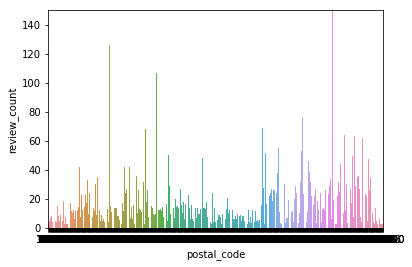

In [353]:
ax_tot = sns.barplot(business_features_2['postal_code'], business_features_2['review_count'])
ax_tot.set(ylim=(0, 150))

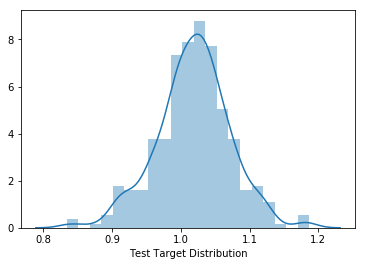

In [630]:
sns.distplot(y_test, axlabel="Test Target Distribution")

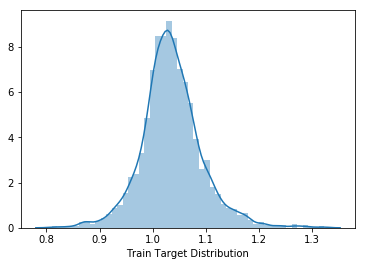

In [631]:
sns.distplot(y_train, axlabel="Train Target Distribution")

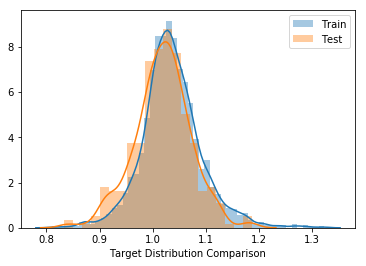

In [632]:
sns.distplot(y_train, label='Train')
sns.distplot(y_test, label='Test', axlabel="Target Distribution Comparison")
plt.legend()